In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd "/content/gdrive/MyDrive/LG"

shortcut_path = "/content/gdrive/MyDrive/LG"
basic_path = "/content/gdrive/MyDrive/test"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 필요한 라이브러리 임포트
from os import makedirs

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image

import matplotlib.pyplot as plt

from datasets import *

In [ ]:
class Generator(nn.Module):
    def __init__(self, channels=3):
        super(Generator, self).__init__()

        # encoder layer 
        def downsampling(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers
        # decoder layer
        def upsampling(in_feat, out_feat, normalize=True):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.ReLU())
            return layers
        # 전체 구조
        self.model = nn.Sequential(
            *downsampling(channels, 64, normalize=False),
            *downsampling(64, 64),  
            *downsampling(64, 128),
            *downsampling(128, 256),
            *downsampling(256, 512),
            nn.Conv2d(512, 4000, 1),
            *upsampling(4000, 512),
            *upsampling(512, 256),
            *upsampling(256, 128),
            *upsampling(128, 64),
            nn.Conv2d(64, channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()

        # discriminator layer
        def discriminator_block(in_filters, out_filters, stride, normalize):
            """Returns layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = channels
        
        # 전체 discriminator
        for out_filters, stride, normalize in [(64, 2, False), (128, 2, True), (256, 2, True), (512, 1, True)]:
            layers.extend(discriminator_block(in_filters, out_filters, stride, normalize))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, 3, 1, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


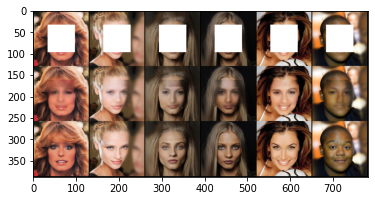

In [ ]:
# 경로 설정
image_path = f"{shortcut_path}/test/image"
# makedirs(f"{basic_path}/test/result", exist_ok=True)
makedirs(f"{basic_path}/result", exist_ok=True)

# device, dtype설정
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# Generator모델 선언 및 pretrained weight load
generator = Generator()
generator.load_state_dict(torch.load(f"{shortcut_path}/test/generator.pth"))

# data preprocessing
transforms_ = [
    transforms.Resize((128, 128), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

generator.cuda() if cuda else None

# Data Wrapper
dataloader = DataLoader(
    ImageDataset(image_path, transforms_=transforms_, mode='test'),
    batch_size=6,
    shuffle=True,
    num_workers=4,
)

# sample result 저장
def save_sample():
    samples, masked_samples, i = next(iter(dataloader))
    samples = Variable(samples.type(Tensor))
    masked_samples = Variable(masked_samples.type(Tensor))
    i = i[0].item()  # Upper-left coordinate of mask

    # Generate inpainted image
    gen_mask = generator(masked_samples)
    filled_samples = masked_samples.clone()
    filled_samples[:, :, i : i + 64, i : i + 64] = gen_mask

    # Save sample
    sample = torch.cat((masked_samples.data, filled_samples.data, samples.data), -2)
    save_image(sample, f"{basic_path}/result/result.png", nrow=6, normalize=True)
    
    # Showing image
    img = plt.imread(f"{basic_path}/result/result.png")
    plt.imshow(img)
    plt.show()

save_sample()